# Test basic classification models for topic segmentation

In [148]:
import model.load_data as ld
import model.scoring_metrics as sm

from sklearn import metrics
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.svm import SVC 
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import xgboost as xgb
xgb.set_config(verbosity=0)
import matplotlib
from sklearn.model_selection import train_test_split 
pd.set_option('display.max_columns', None)
import sys
np.set_printoptions(threshold=sys.maxsize)
from matplotlib import pyplot
import importlib
importlib.reload(sm)
importlib.reload(ld)

<module 'model.load_data' from 'c:\\Users\\marti\\Desktop\\TU Delft\\Q2\\Seminar Social Signal Processing\\code\\our code\\social-signal-processing-project\\source\\model\\load_data.py'>

In [179]:
datasets = """Bed002 Bed003 Bed004 Bed005 Bed006 Bed008 Bed009 Bed010 Bed011 Bed012 Bed013 Bed014 Bed015 Bed016 Bed017 Bmr001 Bmr002 Bmr005 Bmr007 Bmr009 Bmr010 Bmr011 Bmr012 Bmr013 Bmr014 Bmr018 Bmr019 Bmr021 Bmr022 Bmr024 Bmr025 Bmr026 Bmr027 Bmr029 Bns001 Bns002""".split(" ")
results_merged_path = "../results_merged_fixedf0/"

X_train, y_train, X_test, y_test = ld.train_test_split(datasets,results_merged_path,0.3)

all_features = ['pause', 'speakerChange', 'similarity', 'f0_diff', 'f0_baseline_diff']
features_selected = ['similarity']

def filter(data):
    data['similarity'] = data['similarity'][2:-2]
    data['similarity'] = pd.to_numeric(data['similarity'])

    data.fillna(0,inplace=True)

    data = data[features_selected]
    
    return data

X_train = filter(X_train)
X_test = filter(X_test)

## Test on commonly used models

In [174]:
def print_eval(y_pred,y_true):
    k = int(max(1,np.floor((len(y_true)+1)/(2*(sum(y_true)+1)))))
    print('k =',k)

    int_y_pred = (np.array(y_pred))
    int_y_true = (np.array(y_true))

    print('- windiff:',sm.get_windiff(int_y_true,int_y_pred,k))
    print('- pk:',sm.get_pk(int_y_true,int_y_pred,k))
    print('- kkappa:',sm.get_k_kappa(int_y_true,int_y_pred,k))

### Decision Tree classifier

In [175]:
def DecTree(X_train, X_test, y_train, y_test):
    
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)

    # get importance
    importance = clf.feature_importances_
    # summarize feature importance
    for i,v in enumerate(importance):
        print('Feature:',features_selected[i],'->',v)
    # plot feature importance
    pyplot.bar(features_selected, importance)
    pyplot.title('Feature Importance')
    pyplot.show()

    # # plot tree
    # plt.figure(figsize=(15,10))  # set plot size (denoted in inches)
    # tree.plot_tree(clf, max_depth=3, fontsize=10,feature_names=features_selected)
    # plt.show()
    
    return y_predicted

Feature: similarity -> 1.0


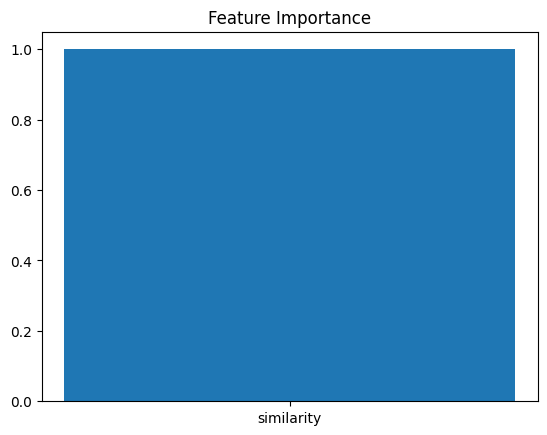

k = 52
- windiff: 0.058662113543508754
- pk: 0.05067382157448625
- kkappa: 0.8943848594993263


In [185]:
DT_y_predicted = DecTree(X_train,X_test,y_train,y_test)
print_eval(DT_y_predicted,y_test)

### XGB Classifier for binary class

In [111]:
def XGB_class(X_train, X_test, y_train, y_test):
    
    clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False)
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    
    return y_predicted

In [183]:
XGBc_y_predicted = XGB_class(X_train,X_test,y_train,y_test)
print_eval(XGBc_y_predicted,y_test)

k = 52
- windiff: 0.4088054149643271
- pk: 0.4088054149643271
- kkappa: 0.0


### SVM for binary class

In [113]:
def SVMc(X_train,X_test,y_train,y_test):
    clf = SVC(kernel='linear',probability=True) 
    clf.fit(X_train, y_train) 
    y_predicted = clf.predict(X_test)
    
    return y_predicted

In [114]:
SVM_y_predicted = SVMc(X_train,X_test,y_train,y_test)
print_eval(SVM_y_predicted,y_test)

- windiff: 0.39006377979187645
- pk: 0.39006377979187645
- kkappa: 0.0


### Random Forest classifier for binary class

In [115]:
def RFc(X_train,X_test,y_train,y_test):
    model = RandomForestClassifier().fit(X_train,y_train)
    y_predicted = model.predict(X_test)
    
    return y_predicted

In [116]:
RFc_y_predicted = RFc(X_train,X_test,y_train,y_test)
print_eval(RFc_y_predicted,y_test)

- windiff: 0.03127447689381224
- pk: 0.02808548729998881
- kkappa: 0.9401994718531342


### Logistic Regressor for binary class

In [117]:
def LR(X_train,X_test,y_train,y_test):
    model = LogisticRegression(random_state=0).fit(X_train,y_train)
    y_predicted = model.predict(X_test)
    
    return y_predicted

In [118]:
LR_y_predicted = LR(X_train,X_test,y_train,y_test)
print_eval(LR_y_predicted,y_test)

- windiff: 0.39006377979187645
- pk: 0.39006377979187645
- kkappa: 0.0


## Multiple runs of each algo with different splits

In [119]:
datasets = """Bed002 Bed003 Bed004 Bed005 Bed006 Bed008 Bed009 Bed010 Bed011 Bed012 Bed013 Bed014 Bed015 Bed016 Bed017 Bmr001 Bmr002 Bmr005 Bmr007 Bmr009 Bmr010 Bmr011 Bmr012 Bmr013 Bmr014 Bmr018 Bmr019 Bmr021 Bmr022 Bmr024 Bmr025 Bmr026 Bmr027 Bmr029 Bns001 Bns002""".split(" ")
results_merged_path = "../results_merged_fixedf0/"

def split_data(split,features_selected):
    X_train, y_train, X_test, y_test = ld.train_test_split(datasets,results_merged_path,split)

    def filter(data):
        data['similarity'] = data['similarity'][2:-2]
        data['similarity'] = pd.to_numeric(data['similarity'])

        data.fillna(0,inplace=True)

        data = data[features_selected]
        
        return data

    X_train = filter(X_train)
    X_test = filter(X_test)

    return X_train, y_train, X_test, y_test

In [160]:
def get_eval(y_pred,y_true):
    k = int(max(1,np.floor((len(y_true)+1)/(2*(sum(y_true)+1)))))
    return sm.get_windiff(np.array(y_true),np.array(y_pred),k),sm.get_pk(np.array(y_true),np.array(y_pred),k),sm.get_k_kappa(np.array(y_true),np.array(y_pred),k)

def get_avg_eval(eval):
    print('- windiff:',sum([row[0] for row in eval])/len([row[0] for row in eval]))
    print('- pk:',sum([row[1] for row in eval])/len([row[1] for row in eval]))
    print('- k-kappa:',sum([row[2] for row in eval])/len([row[2] for row in eval]))

In [165]:
iterations = 10

all_features = ['pause', 'speakerChange', 'similarity', 'f0_diff', 'f0_baseline_diff']
features_selected = ['pause', 'speakerChange', 'similarity', 'f0_diff', 'f0_baseline_diff']
split = 0.3

DT_y_predicted=[]
XGBc_y_predicted=[]
SVM_y_predicted=[]
RFc_y_predicted=[]
LR_y_predicted=[]
for i in range(iterations):
    X_train, y_train, X_test, y_test = split_data(split,features_selected)
    
    DT_y_predicted.append(get_eval(DecTree(X_train,X_test,y_train,y_test),y_test))
    RFc_y_predicted.append(get_eval(RFc(X_train,X_test,y_train,y_test),y_test))
    XGBc_y_predicted.append(get_eval(XGB_class(X_train,X_test,y_train,y_test),y_test))
    SVM_y_predicted.append(get_eval(SVMc(X_train,X_test,y_train,y_test),y_test))
    LR_y_predicted.append(get_eval(LR(X_train,X_test,y_train,y_test),y_test))

C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\s

In [166]:
print('-> Parameters: nbr iterations =',iterations,', split =',split,', features =',features_selected)
print('----- DT:')
get_avg_eval(DT_y_predicted)
print('----- RF:')
get_avg_eval(RFc_y_predicted)
print('----- XGB:')
get_avg_eval(XGBc_y_predicted)
print('----- SVM:')
get_avg_eval(SVM_y_predicted)
print('----- LR:')
get_avg_eval(LR_y_predicted)

-> Parameters: nbr iterations = 10 , split = 0.3 , features = ['pause', 'speakerChange', 'similarity', 'f0_diff', 'f0_baseline_diff']
----- DT:
- windiff: 0.04570931078471889
- pk: 0.039991000097251504
- k-kappa: 0.9155200269177506
----- RF:
- windiff: 0.0366017607559966
- pk: 0.035965139982574536
- k-kappa: 0.9225837369349399
----- XGB:
- windiff: 0.25986996925398287
- pk: 0.22093247134208466
- k-kappa: 0.48003504150921367
----- SVM:
- windiff: 0.3860269114466573
- pk: 0.3860269114466573
- k-kappa: 0.0
----- LR:
- windiff: 0.3861112074508695
- pk: 0.3859723097030489
- k-kappa: 0.0011717197730143295
